# Lag Composites of AEWs
This notebook plots spatial composites of AEW events, for whatever variable specified. Each file output is one variable, for one point along a track, for one level. You can choose to only run the code once, or loop through all points along a track and save multiple separate files.

- NCSU Large Scale and Tropical Dynamics
- A. Thornton & A. Aiyyer
- Version: Jan 2024

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cmaps
import cartopy

import geocat.viz as gv
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

# Any import of metpy will activate the accessors
from metpy.units import units

#from metpy.calc import dewpoint_from_relative_humidity
from metpy.calc import mixing_ratio_from_specific_humidity, relative_humidity_from_dewpoint

from metpy.calc import vorticity

import pandas as pd

### Make selections
- Choose variable, choose level
- May need to modify clevs
- Specify if the variable is a flux or not (Q, SSHF and SLHF are fluxes)

In [2]:
# Selections:
clevs = np.arange(-10000000,10000000,1000000)
level = 600                  # choose 600 or 850
flux = False                 # True for SH, LH & Q 
                             # False for advection

## BUDGET TERMS (ADVECTION)
# ubar dh'/dx
#variab = 'ubar_hp_dx_vint'

# vbar dh'/dy
#variab = 'vbar_hp_dy_vint'    

# wbar dh'/dp
#variab = 'wbar_hp_dp_vint'    

# u' d/dx (hbar)
#variab = 'up_hbar_dx_vint'

# v' d/dy (hbar)
#variab = 'vp_hbar_dy_vint'

# w' d/dp (hbar)
#variab = 'wp_hbar_dp_vint'

# u' dh'/dx
#variab = 'up_hp_dx_vint'   

# v' dh'/dy
#variab = 'vp_hp_dy_vint'

# w' dh'/dp
#variab = 'wp_hp_dp_vint'

## BUDGET TERMS (FLUXES & RADIATION)
# Surface sensible heat flux
# varNam = 'sshf'
# variab = 'SSHF'

# Surface latent heat flux
#varNam = 'slhf'
#variab = 'SLHF'    

# Q_total
#varNam = 'q'
#variab = 'Q'

# MSE
variab = 'mse'
varNam = 'MSE'

# DSE
# variab = 'dse'
# varNam = 'DSE'

In [3]:
# path to the data
if flux == False:
    data_path   = '/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/'+variab+'_filtered_'
if flux == True:
    data_path   = '/glade/scratch/athornton/era5_processed_data/budget_terms/filtered_terms/'+varNam+'_filtered_'
if (variab == 'mse') or (variab == 'dse'):
    data_path   = '/glade/scratch/athornton/era5_processed_data/static/'+variab+'_vint_filtered_'

data_path2  = '/glade/scratch/athornton/era5_processed_data/filtered_era5_full_fields/'+str(level)+'/v_'+str(level)+'_filtered_'
data_path3  = '/glade/scratch/athornton/era5_processed_data/filtered_era5_full_fields/'+str(level)+'/u_'+str(level)+'_filtered_'


year_start  = 1998
year_end    = 2022

data_files  = [data_path  + str(year) + '.nc' for year in range(year_start,year_end+1)]
data_files_v= [data_path2 + str(year) + '.nc' for year in range(year_start,year_end+1)]
data_files_u= [data_path3 + str(year) + '.nc' for year in range(year_start,year_end+1)]


ds          = xr.open_mfdataset(data_files)
ds_v        = xr.open_mfdataset(data_files_v)
ds_u        = xr.open_mfdataset(data_files_u)


# Northern Track based on 850 hPa V Variance
if level == 850:
    stormTrackLons = [-50., -34., -20., -11., 0., 14., 30.]
    stormTrackLats = [12., 12., 18., 21.5, 21.5 , 21.5, 16.]

# Southern Track based on 600 hPa V Variance
if level == 600:
    stormTrackLons = [-50., -34., -22., -11., 0., 14., 30. ]
    stormTrackLats = [12., 12., 12., 12., 9., 8, 8.]

In [4]:
if (variab == 'mse') or (variab == 'dse'):
    ds = ds[variab+'_vint_prime'].compute()
else:
    ds   = ds[variab+'_prime'].compute()*(-1) #multiply advections by -1
ds_v = ds_v.V_prime.compute()
ds_u = ds_u.U_prime.compute()

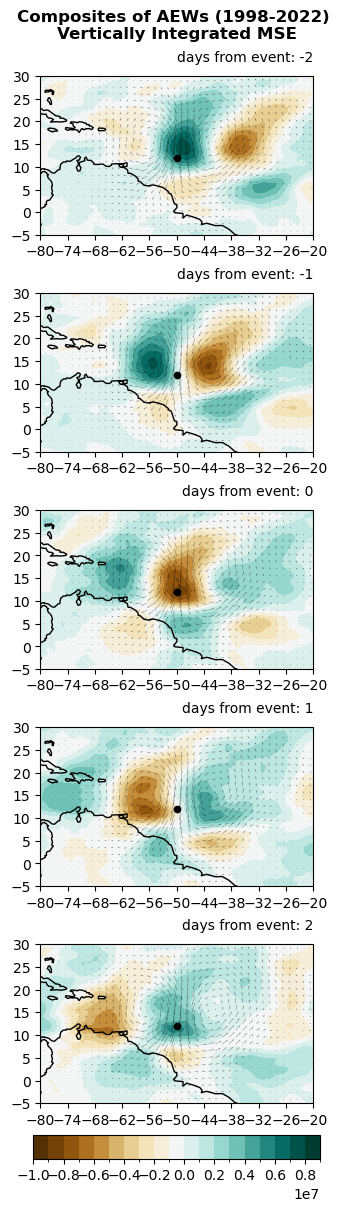

In [7]:
for itrack in range(0,1):#,len(stormTrackLons)):
    lon_base = stormTrackLons[itrack]
    lat_base = stormTrackLats[itrack]
    reference_point =  ds_v.sel(latitude = lat_base, longitude=lon_base)
    std = reference_point.std()

    # events now contains the AEW cases for the composite
    threshold = -1.5*std
    events_index = []

    n = int(len(reference_point))
    for i in range(1, n-1):

        # Condition for local minima
        if(reference_point[i] <= threshold) and (reference_point[i-1] > reference_point[i] < reference_point[i + 1]):
            events_index.append(i)

    wave_passage = ds_v[events_index]
    v_aew = wave_passage.mean(dim='time', keep_attrs=True)
    u_aew = ds_u[events_index].mean(dim='time', keep_attrs=True)
    
    if itrack == 6:
        minlon =  lon_base - 40.
        maxlon =  lon_base + 20.
    
    if itrack < 6:
        minlon = lon_base - 30.
        maxlon = lon_base + 30.
    
    minlat =  -5.
    maxlat =  30.
    projection = ccrs.PlateCarree()


    fig, ax = plt.subplots(5,1, constrained_layout=True, subplot_kw={"projection": projection}, figsize=(10,12))

    ## Quality of image
    plt.rcParams['savefig.dpi'] = 255

    # Add continents
    continents = cartopy.feature.NaturalEarthFeature(name="coastline",
                                                     category="physical",
                                                     scale="110m",
                                                     edgecolor="black",
                                                     facecolor="none")
    [axes.add_feature(continents) for axes in ax.flat]


    # Using a dictionary makes it easy to reuse the same keyword arguments twice for the contours
    kwargs = dict(xlim=(minlon, maxlon),
                  ylim=(minlat, maxlat),
                  xticks=np.linspace(minlon, maxlon, 11),
                  yticks=np.linspace(minlat, maxlat,8),
                  transform=projection,  # ds projection
                  add_colorbar=False,  # don't add individual colorbars for each plot call
                  add_labels=False,  # turn off xarray's automatic Lat, lon labels
    )

    cmap = 'BrBG'
    iplot = 0
    # Lag composites as specified below
    for ih in range (-2,3):
        comp_dates = pd.to_datetime(wave_passage.time) +  pd.Timedelta(24*ih, "hours")
        # make sure that we have only dates within the months July-Sep
        comp_dates = comp_dates[ (comp_dates.month > 6) & (comp_dates.month < 10) ]
        var = ds.sel(time = comp_dates).mean(dim='time', keep_attrs=True)

        # plot scalar field
        p = var.plot.contourf(ax=ax[iplot],cmap=cmap,levels=clevs,**kwargs)
        ax[iplot].scatter(stormTrackLons[itrack],stormTrackLats[itrack],s=20,transform=ccrs.PlateCarree(), facecolor='black')

        
        # Use geocat.viz.util convenience function to set titles and labels
        gv.set_titles_and_labels(ax[iplot],
                             righttitle="days from event: " + str(ih),
                             righttitlefontsize=10)  # Increase the title font size
        
        skip = dict(longitude=slice(None,None,3),latitude=slice(None,None,3))
        lat_uv=u_aew.isel(skip).latitude
        lon_uv=u_aew.isel(skip).longitude
        u_values = u_aew.isel(skip)
        v_values = v_aew.isel(skip)
        ax[iplot].quiver(lon_uv, lat_uv, u_values, v_values, width=0.0015, scale=100., transform=projection, color="black", alpha=0.5)
        iplot=iplot+1

    cb = plt.colorbar(p, ax=ax[iplot-1], orientation='horizontal', pad=0.05,
                          shrink=0.8, aspect=12)

    fig.suptitle("Composites of AEWs (1998-2022) \nVertically Integrated MSE", weight='bold')
    plt.show()
    #plt.savefig(variab+'_'+str(itrack)+' '+str(level)+'.png')
    #plt.close()